In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Non masked

In [2]:
loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"
model       = torch.load(
                   "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

loader       = torch.load(loader_path)
loader_train = loader.get_train_loader()
explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)


model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader_train.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader_train.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 598.95it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

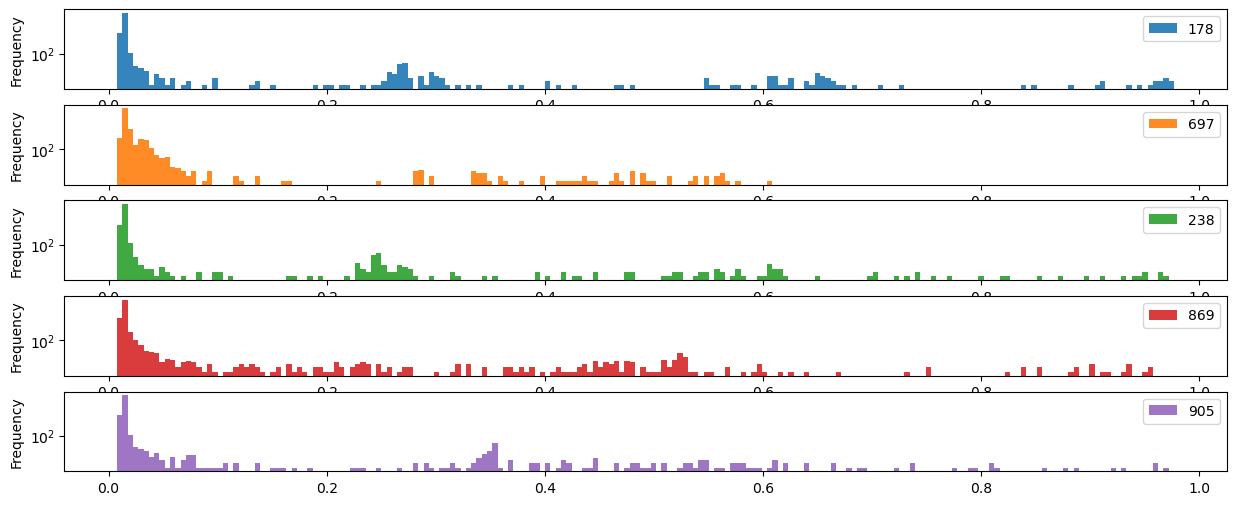

In [4]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [5]:
train_labels = []
for graph in tqdm.tqdm(loader_train.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
labels
pd.Series(labels).to_csv("./results/dataframes/Non_Masked_train_labels.csv")

all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
print(f"{all_graphs_weights_df.shape=}")
all_graphs_weights_df.to_parquet('./results/dataframes/Non_masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')

100%|██████████| 4921/4921 [00:00<00:00, 738361.95it/s]


all_graphs_weights_df.shape=(38428, 4921)


### Process explainer weights

((385, 4921), (38428,))

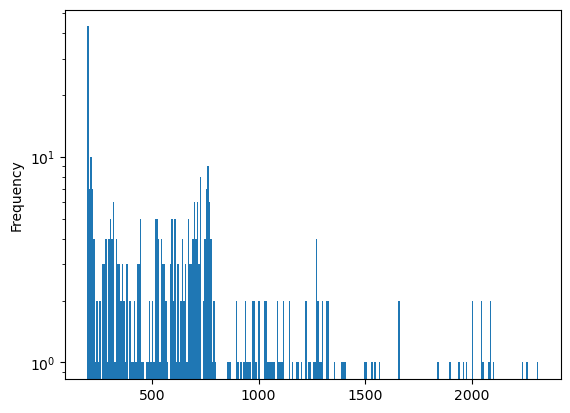

In [6]:
edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)


filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
filtered_graph_weights_df.shape, edge_mask.shape

<AxesSubplot:ylabel='Frequency'>

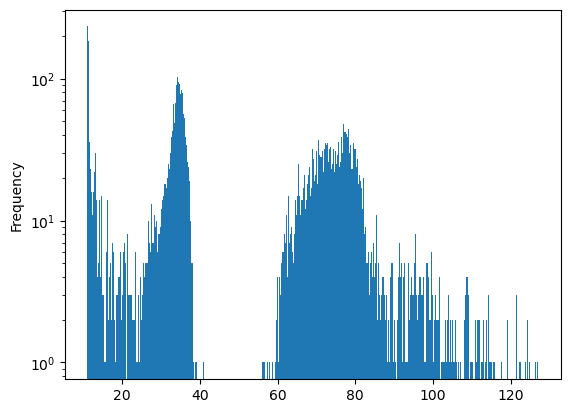

In [7]:
filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [8]:
filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

,29,145,210,232,233,581,620,1906,2088,2105,...,38106,38109,38110,38112,38113,38116,38118,38122,38399,Label
0,0.809316,0.009859,0.009074,0.012321,0.013410,0.010017,0.929856,0.009180,0.063670,0.019508,...,0.010664,0.010530,0.010699,0.011214,0.011244,0.010739,0.010424,0.010930,0.009223,Control
1,0.017071,0.038082,0.037087,0.018849,0.013671,0.097950,0.016154,0.038508,0.021696,0.019854,...,0.066432,0.084973,0.069341,0.070701,0.079504,0.065239,0.081280,0.094387,0.038553,PKU
2,0.944399,0.008392,0.008323,0.013958,0.013923,0.008205,0.012341,0.008272,0.013300,0.010458,...,0.012503,0.012616,0.012769,0.013535,0.013631,0.012363,0.012305,0.013328,0.008262,Control
3,0.014294,0.069493,0.070738,0.014370,0.014184,0.141149,0.014113,0.070187,0.012211,0.013948,...,0.078794,0.099667,0.081202,0.080177,0.094449,0.077868,0.106227,0.122039,0.070767,PKU
4,0.013697,0.104697,0.102954,0.013431,0.013575,0.127064,0.013528,0.103522,0.020217,0.020317,...,0.015499,0.016516,0.015806,0.015822,0.016433,0.015230,0.015265,0.018642,0.102624,PKU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,0.827539,0.008352,0.008498,0.013585,0.013788,0.010808,0.014042,0.008435,0.017067,0.010774,...,0.012979,0.012975,0.012996,0.013712,0.013732,0.013051,0.012640,0.013575,0.008461,Control
4917,0.014083,0.054910,0.057313,0.014264,0.014235,0.072600,0.013971,0.057676,0.009566,0.010917,...,0.058350,0.093472,0.060580,0.060527,0.073615,0.058200,0.080240,0.120887,0.056669,PKU
4918,0.913459,0.008472,0.008594,0.012541,0.013711,0.009763,0.011499,0.008511,0.172643,0.033718,...,0.011826,0.011658,0.011787,0.012497,0.012710,0.011912,0.011520,0.012394,0.008731,Control
4919,0.013974,0.054533,0.054202,0.014184,0.014025,0.074982,0.013967,0.055406,0.011812,0.013063,...,0.109895,0.181505,0.134304,0.130026,0.174806,0.108694,0.180944,0.237277,0.055189,PKU


In [10]:
PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs


,node1,node2,0,1,2,3,4,5,6,7,...,4911,4912,4913,4914,4915,4916,4917,4918,4919,4920
29,GLYtp,gly_x,0.809316,0.017071,0.944399,0.014294,0.013697,0.014400,0.016846,0.013861,...,0.014113,0.023876,0.939117,0.014372,0.924866,0.827539,0.014083,0.913459,0.013974,0.013647
145,r1775,phe_L_e,0.009859,0.038082,0.008392,0.069493,0.104697,0.054944,0.045725,0.081173,...,0.051504,0.041776,0.008341,0.054734,0.010928,0.008352,0.054910,0.008472,0.054533,0.100641
210,r1764,phe_L_e,0.009074,0.037087,0.008323,0.070738,0.102954,0.056667,0.044050,0.081458,...,0.051922,0.035115,0.008064,0.054673,0.008636,0.008498,0.057313,0.008594,0.054202,0.102157
232,SERDGLYexR,ser_D_e,0.012321,0.018849,0.013958,0.014370,0.013431,0.015026,0.020074,0.013916,...,0.014359,0.029213,0.013197,0.014674,0.013804,0.013585,0.014264,0.012541,0.014184,0.013492
233,SERDGLYexR,ser_D_c,0.013410,0.013671,0.013923,0.014184,0.013575,0.014927,0.019511,0.013744,...,0.013654,0.027464,0.013792,0.014596,0.013832,0.013788,0.014235,0.013711,0.014025,0.013558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38113,glu_L_c,r1294,0.011244,0.079504,0.013631,0.094449,0.016433,0.244240,0.469874,0.029872,...,0.036766,0.505658,0.013501,0.821198,0.014351,0.013732,0.073615,0.012710,0.174806,0.014933
38116,glu_L_c,r1350,0.010739,0.065239,0.012363,0.077868,0.015230,0.149757,0.356885,0.016367,...,0.032906,0.319373,0.012532,0.588149,0.013105,0.013051,0.058200,0.011912,0.108694,0.014540
38118,glu_L_c,r1339,0.010424,0.081280,0.012305,0.106227,0.015265,0.249086,0.564752,0.015678,...,0.037034,0.602232,0.012227,0.835052,0.012747,0.012640,0.080240,0.011520,0.180944,0.014614
38122,glu_L_c,r1096,0.010930,0.094387,0.013328,0.122039,0.018642,0.302735,0.615896,0.033883,...,0.040938,0.641238,0.013157,0.864087,0.014171,0.013575,0.120887,0.012394,0.237277,0.015303


In [ ]:

edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Non_masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')